In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [ ]:
import os

import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from numpy import asarray

from matplotlib import pyplot as plt

from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

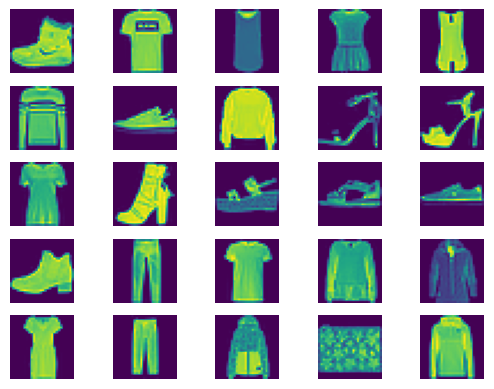

In [ ]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [ ]:
trainX[0].shape

(28, 28)

In [ ]:
# image preprocessing

trainX = trainX.reshape(60000, 28, 28, 1)
testX = testX.reshape(10000, 28, 28, 1)

In [ ]:
trainX[0].shape

(28, 28, 1)

In [ ]:
# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.

#Unlike regular GAN here we are also providing number of classes as input.
#Input to the model will be both images and labels.
def define_discriminator(in_shape=(28,28,1), n_classes=10):

    # label input
  in_label = Input(shape=(1,))  #Shape 1
  # embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
    #This vector of size 50 will be learnt by the discriminator
  li = Embedding(n_classes, 50)(in_label) #Shape 1,50
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024.
  li = Dense(n_nodes)(li)  #Shape = 1, 1024
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1


  # image input
  in_image = Input(shape=in_shape) #32x32x3
  # concat label as a channel
  merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)

  # downsample: This part is same as unconditional GAN upto the output layer.
  #We will combine input label with input image and supply as inputs to the model.

  uncon = Sequential()

  uncon.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  uncon.add(LeakyReLU(alpha=0.2))

  uncon.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  uncon.add(LeakyReLU(alpha=0.2))

  uncon.add(Flatten())
  uncon.add(Dropout(0.4))
  uncon.add(Dense(1, activation='sigmoid'))

  output = uncon(merge)
  # define model
  ##Combine input label with input image and supply as inputs to the model.

  model = Model([in_image, in_label], output)
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)

  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

test_discr = define_discriminator()
print(test_discr.summary())


# define the standalone generator model
#latent vector and label as inputs

def define_generator(latent_dim, n_classes=10):

  # label input
  in_label = Input(shape=(1,))  #Input of dimension 1
  # embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
  li = Embedding(n_classes, 50)(in_label) #Shape 1,50

  # linear multiplication
  n_nodes = 7 * 7  # To match the dimensions for concatenation later in this step.
  li = Dense(n_nodes)(li) #1,64
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)


  # image generator input
  in_lat = Input(shape=(latent_dim,))  #Input of dimension 100

  # foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer.
    #While defining model inputs we will combine input label and the latent input.
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)  #shape=8192
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen) #Shape=8x8x128
  # merge image gen and label input
  merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)

  uncon = Sequential()
  # upsample to 14x14
  uncon.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #14x14x128
  uncon.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  uncon.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #28x28x128
  uncon.add(LeakyReLU(alpha=0.2))

  uncon.add(Conv2D(1, (8,8), activation='tanh', padding='same'))

  output = uncon(merge)

  # define model
  model = Model([in_lat, in_label], output)
  return model   #Model not compiled as it is not directly trained like the discriminator.

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 1, 50)                500       ['input_9[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 1, 784)               39984     ['embedding_4[0][0]']         
                                                                                                  
 input_10 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                            

In [ ]:
# #Generator is trained via GAN combined model.
# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant.
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.

    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3

	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 dense_11 (Dense)            (None, 6272)                 633472    ['input_12[0][0]']            
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 50)                500       ['input_11[0][0]']            
                                                                                            

In [ ]:
# load cifar images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()   #cifar
	# convert to floats and scale
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale
                            #original images to -1 to 1 to match the output of generator.
	return [X, trainy]

# # select real samples
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another
#half batch of fake images.
#For each real image we assign a label 1 and for fake we assign label 0.
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

In [ ]:
# defining empty lists to store the loss function values of the Discriminator and Generator

d_loss_real_list = []
d_loss_fake_list = []
g_loss_list = []

In [ ]:
# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator.
#Feed both set of images into the Discriminator.
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss.
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                            #and a half batch of fake samples, combined a single batch.
	# manually enumerate epochs
  for i in range(n_epochs):
		# enumerate batches over the training set
    for j in range(bat_per_epo):

             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
      d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

			# generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
      d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

			# prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			# create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
      print('Epoch>%d, Batch%d/%d, d_real=%.3f, d_fake=%.3f, g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

    d_loss_real_list.append(d_loss_real)
    d_loss_fake_list.append(d_loss_fake)
    g_loss_list.append(g_loss)

  # save the generator model
  g_model.save('/content/drive/MyDrive/Colab Notebooks/CGAN_fashion-mnist_generator.keras')
  plt.plot(d_loss_real_list, label='Discr. Real')
  plt.plot(d_loss_fake_list, label='Discr. Fake')
  plt.plot(g_loss_list, label='Generator')
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator

# Check if the file exists
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/CGAN_fashion-mnist_generator.keras'):
    generator = load_model('/content/drive/MyDrive/Colab Notebooks/CGAN_fashion-mnist_generator.keras')
else:
	generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch309/468, d_real=0.642, d_fake=0.671, g=0.768
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch310/468, d_real=0.684, d_fake=0.676, g=0.764
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch311/468, d_real=0.642, d_fake=0.684, g=0.750
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch312/468, d_real=0.658, d_fake=0.689, g=0.730
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch313/468, d_real=0.666, d_fake=0.664, g=0.732
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch314/468, d_real=0.646, d_fake=0.680, g=0.758
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch315/468, d_real=0.657, d_fake=0.694, g=0.748
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch316/468, d_real=0.640, d_fake=0.715, g=0.767
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch317/

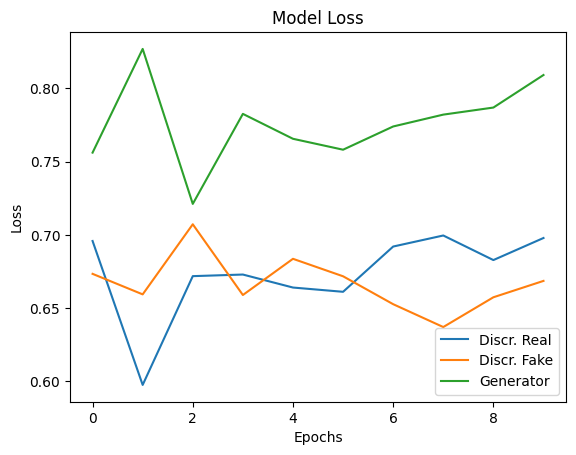

In [ ]:
# train model
#1
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch309/468, d_real=0.661, d_fake=0.668, g=0.767
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch310/468, d_real=0.675, d_fake=0.687, g=0.765
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch311/468, d_real=0.677, d_fake=0.638, g=0.783
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch312/468, d_real=0.692, d_fake=0.657, g=0.758
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch313/468, d_real=0.671, d_fake=0.690, g=0.729
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch314/468, d_real=0.671, d_fake=0.728, g=0.762
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch315/468, d_real=0.671, d_fake=0.686, g=0.768
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch316/468, d_real=0.680, d_fake=0.660, g=0.798
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch317/

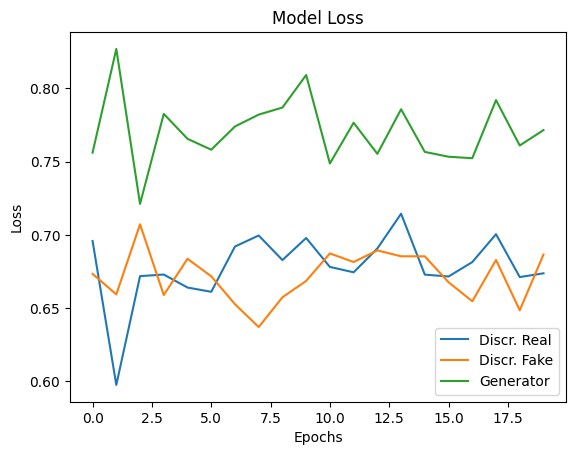

In [ ]:
#2
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch309/468, d_real=0.688, d_fake=0.678, g=0.783
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch310/468, d_real=0.697, d_fake=0.616, g=0.778
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch311/468, d_real=0.707, d_fake=0.670, g=0.790
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch312/468, d_real=0.652, d_fake=0.688, g=0.782
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch313/468, d_real=0.687, d_fake=0.652, g=0.737
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch314/468, d_real=0.651, d_fake=0.697, g=0.736
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch315/468, d_real=0.629, d_fake=0.661, g=0.746
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch316/468, d_real=0.650, d_fake=0.665, g=0.774
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch317/

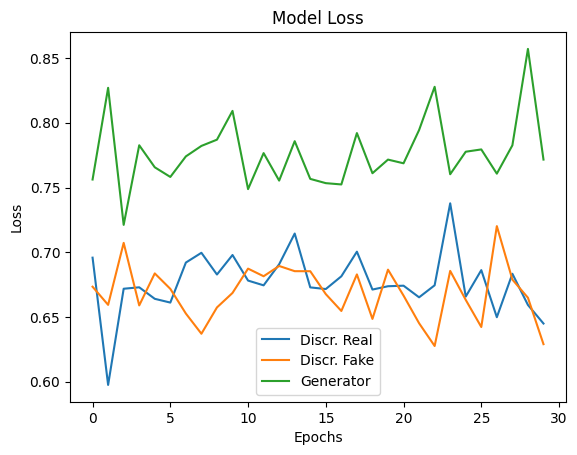

In [ ]:
#3
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch309/468, d_real=0.688, d_fake=0.692, g=0.759
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch310/468, d_real=0.695, d_fake=0.682, g=0.786
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch311/468, d_real=0.691, d_fake=0.658, g=0.770
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch312/468, d_real=0.703, d_fake=0.682, g=0.768
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch313/468, d_real=0.662, d_fake=0.655, g=0.789
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch314/468, d_real=0.700, d_fake=0.667, g=0.787
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch315/468, d_real=0.651, d_fake=0.703, g=0.757
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch316/468, d_real=0.694, d_fake=0.678, g=0.771
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch317/

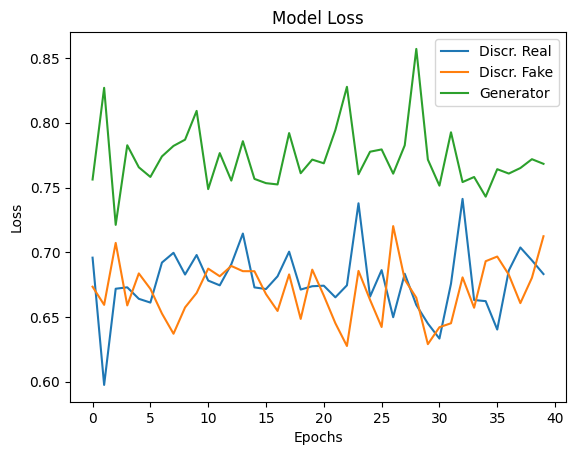

In [ ]:
#4
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 11ms/step
Epoch>5, Batch309/468, d_real=0.659, d_fake=0.710, g=0.745
2/2 [==============================] - 0s 11ms/step
Epoch>5, Batch310/468, d_real=0.663, d_fake=0.721, g=0.744
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch311/468, d_real=0.703, d_fake=0.649, g=0.785
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch312/468, d_real=0.690, d_fake=0.679, g=0.763
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch313/468, d_real=0.677, d_fake=0.709, g=0.764
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch314/468, d_real=0.679, d_fake=0.714, g=0.747
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch315/468, d_real=0.668, d_fake=0.692, g=0.776
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch316/468, d_real=0.699, d_fake=0.672, g=0.741
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch31

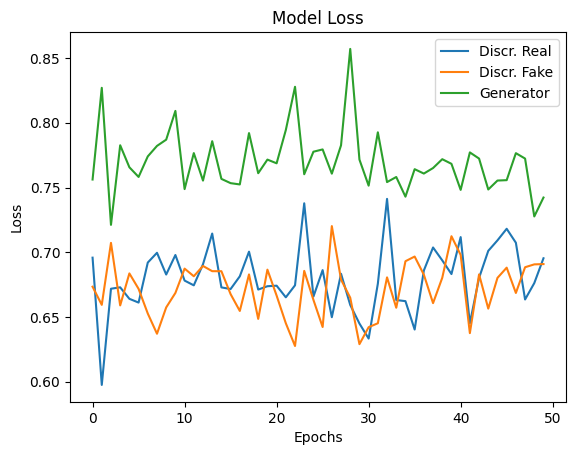

In [ ]:
#5
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch309/468, d_real=0.676, d_fake=0.691, g=0.734
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch310/468, d_real=0.695, d_fake=0.687, g=0.764
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch311/468, d_real=0.703, d_fake=0.657, g=0.752
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch312/468, d_real=0.701, d_fake=0.677, g=0.757
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch313/468, d_real=0.695, d_fake=0.691, g=0.764
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch314/468, d_real=0.686, d_fake=0.675, g=0.745
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch315/468, d_real=0.684, d_fake=0.684, g=0.761
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch316/468, d_real=0.646, d_fake=0.674, g=0.770
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch317/

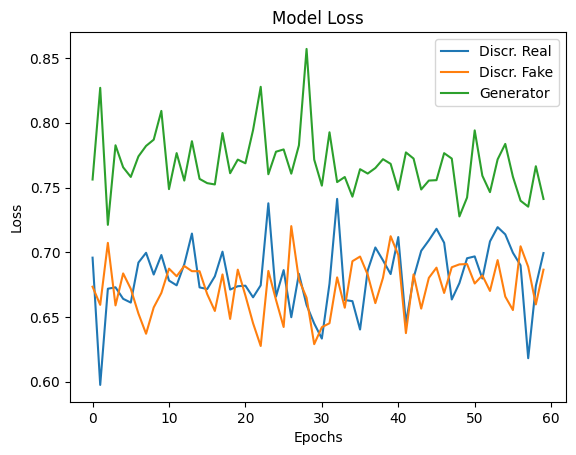

In [ ]:
#6
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch309/468, d_real=0.715, d_fake=0.680, g=0.756
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch310/468, d_real=0.688, d_fake=0.658, g=0.761
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch311/468, d_real=0.681, d_fake=0.693, g=0.741
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch312/468, d_real=0.682, d_fake=0.676, g=0.759
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch313/468, d_real=0.626, d_fake=0.696, g=0.758
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch314/468, d_real=0.667, d_fake=0.702, g=0.756
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch315/468, d_real=0.687, d_fake=0.658, g=0.753
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch316/468, d_real=0.675, d_fake=0.696, g=0.765
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch317/

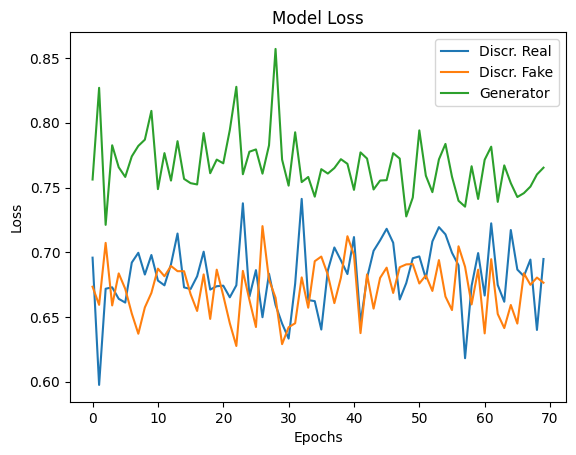

In [ ]:
#7
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch309/468, d_real=0.696, d_fake=0.670, g=0.764
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch310/468, d_real=0.657, d_fake=0.673, g=0.765
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch311/468, d_real=0.669, d_fake=0.689, g=0.762
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch312/468, d_real=0.701, d_fake=0.665, g=0.758
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch313/468, d_real=0.692, d_fake=0.680, g=0.755
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch314/468, d_real=0.667, d_fake=0.667, g=0.736
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch315/468, d_real=0.680, d_fake=0.711, g=0.752
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch316/468, d_real=0.670, d_fake=0.675, g=0.747
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch317/

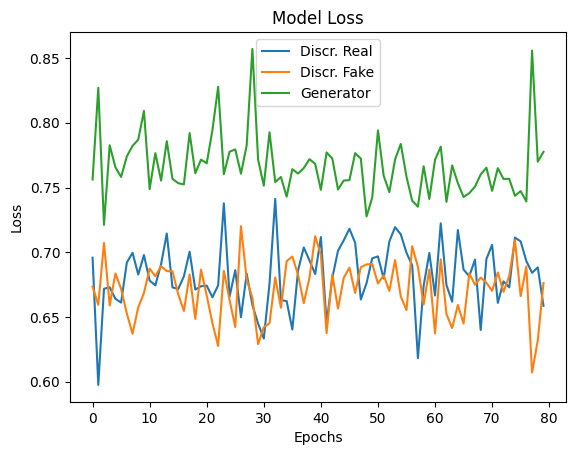

In [ ]:
#8
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch309/468, d_real=0.712, d_fake=0.717, g=0.732
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch310/468, d_real=0.688, d_fake=0.707, g=0.758
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch311/468, d_real=0.685, d_fake=0.724, g=0.747
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch312/468, d_real=0.691, d_fake=0.683, g=0.731
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch313/468, d_real=0.688, d_fake=0.690, g=0.756
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch314/468, d_real=0.715, d_fake=0.664, g=0.755
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch315/468, d_real=0.686, d_fake=0.708, g=0.746
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch316/468, d_real=0.679, d_fake=0.683, g=0.762
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch317/

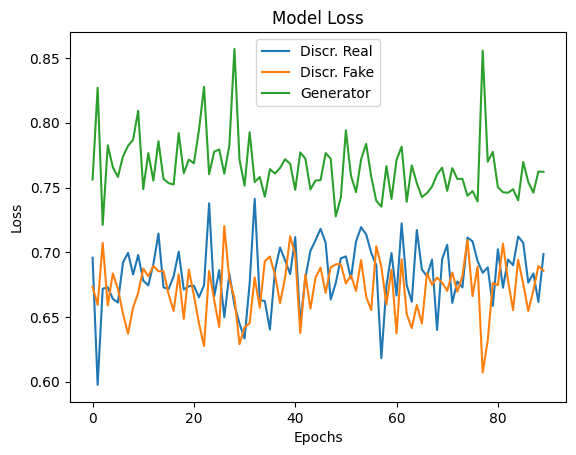

In [ ]:
#9
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Epoch>5, Batch309/468, d_real=0.678, d_fake=0.690, g=0.736
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch310/468, d_real=0.678, d_fake=0.710, g=0.753
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch311/468, d_real=0.684, d_fake=0.682, g=0.747
2/2 [==============================] - 0s 7ms/step
Epoch>5, Batch312/468, d_real=0.719, d_fake=0.689, g=0.747
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch313/468, d_real=0.670, d_fake=0.708, g=0.733
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch314/468, d_real=0.695, d_fake=0.697, g=0.744
2/2 [==============================] - 0s 6ms/step
Epoch>5, Batch315/468, d_real=0.683, d_fake=0.661, g=0.749
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch316/468, d_real=0.687, d_fake=0.677, g=0.762
2/2 [==============================] - 0s 5ms/step
Epoch>5, Batch317/

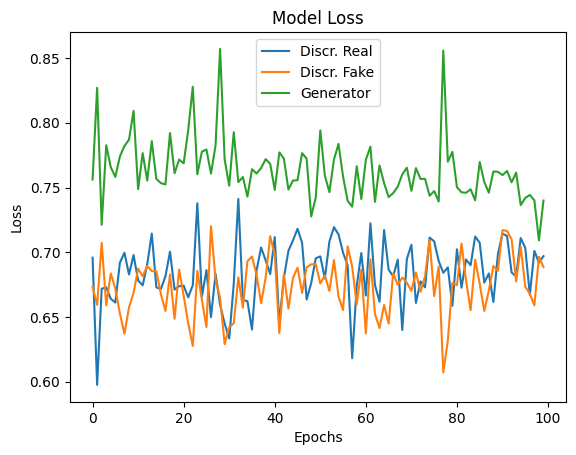

In [ ]:
#10
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10)

In [ ]:
generator.save('/content/drive/MyDrive/Colab Notebooks/CGAN_fashion-mnist_generator.keras')

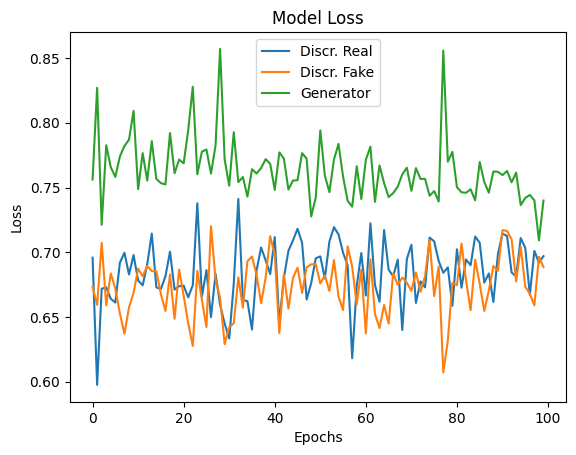

In [ ]:
# plot the losses
plt.plot(d_loss_real_list, label='Discr. Real')
plt.plot(d_loss_fake_list, label='Discr. Fake')
plt.plot(g_loss_list, label='Generator')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Now, let us load the generator model and generate images
# Lod the trained model and generate a few images

# load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/CGAN_fashion-mnist_generator.keras') #Model trained for 100 epochs


#
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck


4/4 [==============================] - 0s 70ms/step


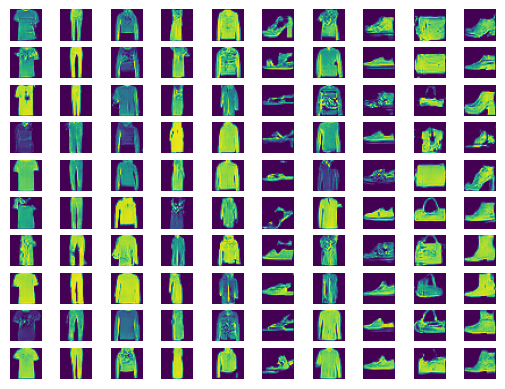

In [ ]:
# generate multiple images

latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images

show_plot(X, 10)